# Notebook 3 : Data preprocessing

## Configuration de l'environnement

In [122]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import pickle
from scipy.stats import chi2_contingency

# Sklearn preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import VarianceThreshold


## Parameters

In [123]:
# Set random seed for reproducibility
R_seed = 42
np.random.seed(R_seed)

# Data path
data_path = '../data/data_processed/data_feature_engineering.csv'
data_description_path = '../data/data_raw/Dictionnaire_des_données.xlsx'

## Utility functions

In [124]:
def cramers_V(var1,var2) :
  crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
  stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
  obs = np.sum(crosstab) # Number of observations
  mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
  return (stat/(obs*mini))

## Data Loading

In [125]:
df = pd.read_csv(data_path)
print(df.shape)
df.head()

(20000, 70)


,ApplicationDate,Age,AnnualIncome,CreditScore,EmploymentStatus,EducationLevel,Experience,LoanAmount,LoanDuration,MaritalStatus,...,JobStabilityIndex,DependentsBurdenRatio,RiskExposureScore,OverleveragedFlag,Age_x_CreditScore,LoanAmount_x_InterestRate,CreditUtilization_x_Income,JobTenure_x_CreditScore,NormalizedDebt,NormalizedIncome
0,2018-01-01,45,39948,617,Employed,Master,22,13152,48,Married,...,0.478261,0.666667,0.539413,0,27765,2993.258818,14158.287021,6787,0.151132,0.675225
1,2018-01-02,38,39709,628,Employed,Associate,15,26045,48,Single,...,0.187500,0.500000,0.720126,0,23864,5237.053629,3487.521080,1884,0.220018,0.671186
2,2018-01-03,47,40724,570,Employed,Bachelor,26,17627,36,Married,...,0.222222,0.666667,0.706886,0,26790,3746.583770,5596.051981,3420,24.754898,0.688342
3,2018-01-04,58,69084,545,Employed,High School,34,37898,96,Single,...,0.142857,0.500000,0.749343,1,31610,11403.919361,18485.989769,2725,0.053995,1.167700
4,2018-01-05,37,103264,594,Employed,Associate,17,9184,36,Married,...,0.277778,0.500000,0.149094,0,21978,1616.293802,33099.759774,2970,0.076143,1.745431


In [126]:
y = df["RiskScore"]
X = df.drop(columns=["RiskScore"])
X.drop(columns=["ApplicationDate"], inplace=True)
X.drop(columns=["LoanApproved"], inplace=True)

X.shape

(20000, 67)

Il faut bien penser à drop les deux colonnes "ApplicationDate" et "LoanApproved" avant de commencer le preprocessing. 
- "ApplicationDate" car on ne peut pas utiliser une date pour faire de la prédiction. Nous avons déjà extrait des features temporelles dans le notebook de feature engineering. (mois, année, jour de la semaine, etc)
- "LoanApproved" car c'est la variable cible que nous voulons prédire. Elle ne doit pas être utilisée comme feature dans le modèle. On cherche justement à prédire le risque de crédit. Si nous avons la variable qui indique le crédit a été octroyé alors cela biaise complètement le modèle et n'a plus de sens concret.

In [127]:
variables_na = []
variables_numeriques = []
variables_01 = []
variables_categorielles = []
for colu in X.columns:
    if True in X[colu].isna().unique() :
        variables_na.append(X[colu])
    else :
        if str(X[colu].dtypes) in ["int32","int64","float64"]:
            if len(X[colu].unique())==2 :
                variables_categorielles.append(X[colu])
            else :
                variables_numeriques.append(X[colu])
        else :
            if len(X[colu].unique())==2 :
                variables_categorielles.append(X[colu])
            else :
                variables_categorielles.append(X[colu])

In [128]:
print(len(variables_categorielles))
print(len(variables_numeriques))

11
56


In [129]:
len(variables_numeriques)+len(variables_categorielles) == X.shape[1]

True

## Numerical features variance analysis

In [130]:
vars_numeriques = pd.DataFrame(variables_numeriques).transpose()
variances = vars_numeriques.var()
faible_variance = variances[variances < 0.01]
print(faible_variance)

BaseInterestRate         0.001261
InterestRate             0.001781
CheckingToIncomeRatio    0.004628
InterestSpread           0.000541
dtype: float64


In [131]:
vars_numeriques["CheckingToIncomeRatio"]

0        0.030088
1        0.087132
2        0.021977
3        0.017616
4        0.048235
           ...   
19995    0.113615
19996    0.003716
19997    0.015237
19998    0.006337
19999    0.033178
Name: CheckingToIncomeRatio, Length: 20000, dtype: float64

Les variables obtenues sont normales car les taux d'intérêts sont relativement faibles et similaires entre eux. On peut la laisser telle quelle. Pour la variable "CheckingToIncomeRatio", la variance est très faible car la majorité des emprunteurs ont un ratio similaire, ce qui reflète une tendance générale dans les comportements financiers des emprunteurs. Cela peut indiquer que cette variable n'apporte pas beaucoup d'information discriminante pour le modèle prédictif. On a décidé de la laisser pour l'instant mais on pourra la dropper plus tard si besoin.

## Correlation between numerical variables

In [132]:
vars_numeriques = vars_numeriques.reindex(sorted(vars_numeriques.columns), axis=1)
#Corrélation de Pearson
correlations_num = vars_numeriques.corr(method='pearson')
correlations_num 

,Age,Age_x_CreditScore,AnnualIncome,ApplicationDayOfWeek,ApplicationMonth,ApplicationQuarter,AssetsToLiabilitiesRatio,BaseInterestRate,CareerProgressIndex,CheckingAccountBalance,...,PaymentHistory,RecentInquiryRate,RiskExposureScore,SavingsAccountBalance,SavingsToIncomeRatio,TotalAssets,TotalDebtToIncomeRatio,TotalLiabilities,TotalLoanCost,UtilityBillsPaymentHistory
Age,1.000000,0.964586,0.144774,0.001538,-0.005538,-0.007147,0.013165,-0.238995,0.930310,0.010145,...,-0.002487,-0.009978,-0.099684,0.004236,-0.048540,0.012210,-0.111800,-0.001197,-0.035391,-0.005601
Age_x_CreditScore,0.964586,1.000000,0.154147,0.002673,-0.008130,-0.009129,0.012670,-0.402004,0.892161,0.010125,...,-0.002055,-0.011294,-0.114844,0.001448,-0.053776,0.010336,-0.128300,-0.003384,-0.052703,-0.006759
AnnualIncome,0.144774,0.154147,1.000000,-0.008363,0.006510,0.009778,0.000902,-0.074549,0.140696,0.008613,...,0.003715,0.000820,-0.482802,-0.001397,-0.265644,-0.005158,-0.532033,-0.002353,-0.008725,-0.012351
ApplicationDayOfWeek,0.001538,0.002673,-0.008363,1.000000,-0.000258,-0.000190,-0.013658,-0.001698,0.001534,-0.000148,...,0.017081,-0.008800,0.001603,-0.008658,-0.009292,0.000045,0.001208,-0.005746,0.003677,0.001440
ApplicationMonth,-0.005538,-0.008130,0.006510,-0.000258,1.000000,0.971291,0.010237,0.009025,-0.002933,0.015780,...,-0.004608,-0.007509,-0.003678,-0.005710,-0.008123,-0.002765,-0.007973,0.001434,-0.004100,-0.003041
ApplicationQuarter,-0.007147,-0.009129,0.009778,-0.000190,0.971291,1.000000,0.008562,0.009245,-0.005257,0.015454,...,-0.000864,-0.007738,-0.003739,-0.005026,-0.008674,-0.002939,-0.009111,0.002233,-0.002636,-0.000460
AssetsToLiabilitiesRatio,0.013165,0.012670,0.000902,-0.013658,0.010237,0.008562,1.000000,-0.007225,0.011722,0.003577,...,-0.004584,-0.003143,-0.006464,0.000522,-0.006018,0.520038,-0.007072,-0.215814,-0.004713,0.001949
BaseInterestRate,-0.238995,-0.402004,-0.074549,-0.001698,0.009025,0.009245,-0.007225,1.000000,-0.231619,-0.003554,...,-0.002999,0.004399,0.118143,0.006012,0.031530,-0.007368,0.131853,0.007140,0.616543,-0.005517
CareerProgressIndex,0.930310,0.892161,0.140696,0.001534,-0.002933,-0.005257,0.011722,-0.231619,1.000000,0.007166,...,0.000535,-0.011224,-0.103906,0.004687,-0.048352,0.015621,-0.113782,0.002993,-0.037539,-0.004293
CheckingAccountBalance,0.010145,0.010125,0.008613,-0.000148,0.015780,0.015454,0.003577,-0.003554,0.007166,1.000000,...,-0.017384,0.002814,-0.004925,-0.000392,-0.007827,0.003322,-0.006630,0.001473,0.004461,-0.005696


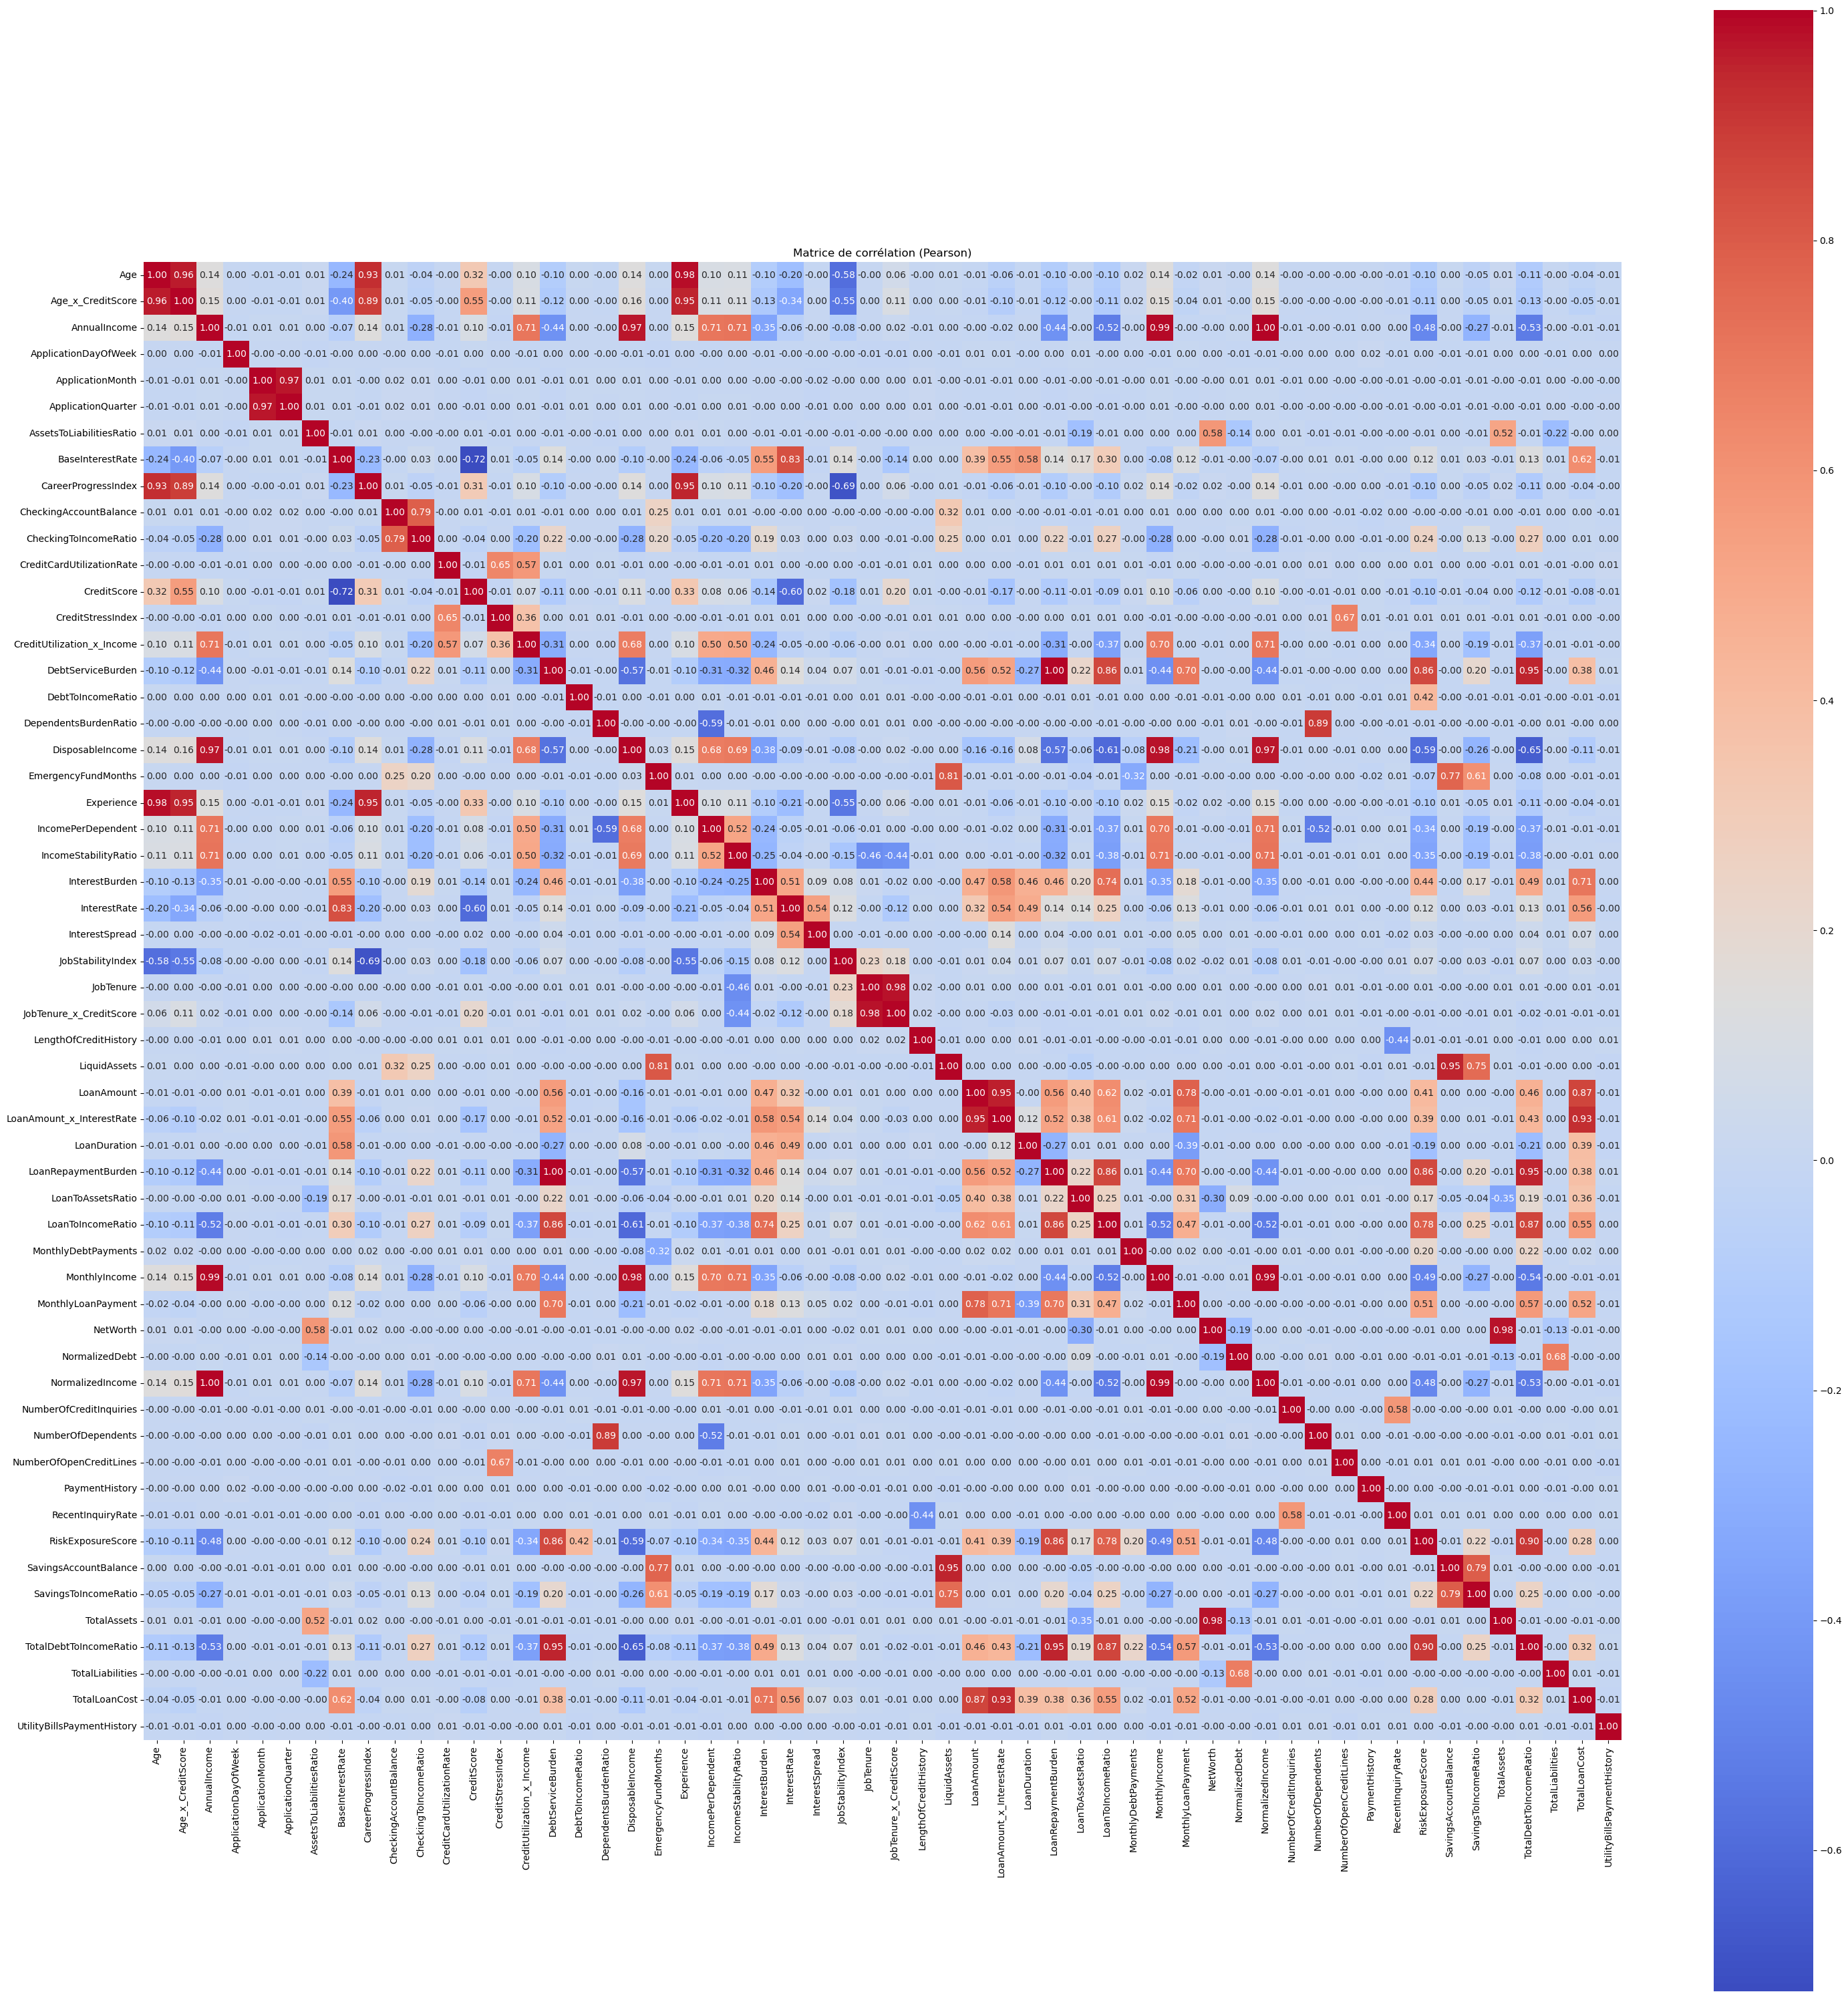

In [133]:
# Affichage de la matrice de corrélation sous forme de heatmap
plt.figure(figsize=(30, 30))
sns.heatmap(correlations_num, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Matrice de corrélation (Pearson)')
plt.tight_layout()
plt.show()

In [134]:
#On repère les variables trop corrélées
nb_variables = correlations_num.shape[0]
for i in range(nb_variables):
  for j in range(i+1,nb_variables) :
    if abs(correlations_num.iloc[i,j]) > 0.8 :
        print("\n",correlations_num.index.to_numpy()[i]+" et "+
              correlations_num.columns[j] + " sont trop dépendantes, corr = " + str(correlations_num.iloc[i,j]))


 Age et Age_x_CreditScore sont trop dépendantes, corr = 0.9645863761734313

 Age et CareerProgressIndex sont trop dépendantes, corr = 0.9303096604439369

 Age et Experience sont trop dépendantes, corr = 0.9829802792421133

 Age_x_CreditScore et CareerProgressIndex sont trop dépendantes, corr = 0.8921608248771087

 Age_x_CreditScore et Experience sont trop dépendantes, corr = 0.9522181454757533

 AnnualIncome et DisposableIncome sont trop dépendantes, corr = 0.9668994350331592

 AnnualIncome et MonthlyIncome sont trop dépendantes, corr = 0.9899107753669869

 AnnualIncome et NormalizedIncome sont trop dépendantes, corr = 1.000000000000001

 ApplicationMonth et ApplicationQuarter sont trop dépendantes, corr = 0.9712909680750259

 BaseInterestRate et InterestRate sont trop dépendantes, corr = 0.8345565713776919

 CareerProgressIndex et Experience sont trop dépendantes, corr = 0.9494297776579589

 DebtServiceBurden et LoanRepaymentBurden sont trop dépendantes, corr = 1.0

 DebtServiceBurde

Nous obtenons beacoup de variables corrélées entre elles ce qui est normal car plusieurs variables sont liées à des aspects similaires de la situation financière des emprunteurs. Par exemple, des variables comme "DebtToIncomeRatio" et "CreditCardUtilizationRate" mesurent toutes deux la charge financière relative des emprunteurs par rapport à leurs revenus ou limites de crédit. De même, des variables telles que "AnnualIncome" et "LoanAmount" peuvent être corrélées car les emprunteurs avec des revenus plus élevés ont tendance à demander des prêts plus importants.De plus, les variables calculées lors du feature engineering sont corrélées avec celles utilisées pour les créer, ce qui est attendu.

Les variables corrélées sont un problème pour les modèles linéaires tels que ridge, lasso, elasticNet ... Il faut donc les traiter avant d'entrainer ces modèles là. Par contre, les modèles basés sur des arbres (RandomForest, XGBoost, LightGBM ...) ne sont pas impactés par la multicolinéarité. On peut donc choisir de ne pas traiter les variables corrélées si on utilise uniquement des modèles basés sur des arbres. 

Au final nous avons décidé de faire des pipelines de preprocessing différents :
- Un pipeline "complet" qui ne traite pas les variables corrélées, à utiliser uniquement avec des modèles basés sur des arbres.
- Un pipeline "all models" qui traite les variables corrélées en dropant certaines d'entre elles, à utiliser avec tous les modèles, y compris les modèles linéaires

In [135]:
# Threshold for "too correlated"
threshold = 0.8

# Correlation with target
corr_with_y = vars_numeriques.corrwith(y).abs()

# Store variables to drop
to_drop = set()

print("Variables trop corrélées (|corr| >", threshold, ")\n")

nb_variables = correlations_num.shape[0]

for i in range(nb_variables):
    for j in range(i+1, nb_variables):
        corr_ij = correlations_num.iloc[i, j]

        if abs(corr_ij) > threshold:
            var_i = correlations_num.index[i]
            var_j = correlations_num.columns[j]

            print(f"{var_i}  <->  {var_j}")
            print(f"  corr(var_i, var_j) = {corr_ij:.3f}")
            print(f"  corr({var_i}, y) = {corr_with_y[var_i]:.3f}")
            print(f"  corr({var_j}, y) = {corr_with_y[var_j]:.3f}")

            # --- DROP LOGIC ---
            if corr_with_y[var_i] < corr_with_y[var_j]:
                to_drop.add(var_i)
                print(f"  → drop {var_i}")
            else:
                to_drop.add(var_j)
                print(f"  → drop {var_j}")

            print("-" * 50)

# Final reduced dataset
vars_numeriques_reduced = vars_numeriques.drop(columns=list(to_drop))

print("\nVariables supprimées :", list(to_drop))
print("Nombre de variables restantes :", vars_numeriques_reduced.shape[1])

Variables trop corrélées (|corr| > 0.8 )

Age  <->  Age_x_CreditScore
  corr(var_i, var_j) = 0.965
  corr(Age, y) = 0.164
  corr(Age_x_CreditScore, y) = 0.211
  → drop Age
--------------------------------------------------
Age  <->  CareerProgressIndex
  corr(var_i, var_j) = 0.930
  corr(Age, y) = 0.164
  corr(CareerProgressIndex, y) = 0.168
  → drop Age
--------------------------------------------------
Age  <->  Experience
  corr(var_i, var_j) = 0.983
  corr(Age, y) = 0.164
  corr(Experience, y) = 0.166
  → drop Age
--------------------------------------------------
Age_x_CreditScore  <->  CareerProgressIndex
  corr(var_i, var_j) = 0.892
  corr(Age_x_CreditScore, y) = 0.211
  corr(CareerProgressIndex, y) = 0.168
  → drop CareerProgressIndex
--------------------------------------------------
Age_x_CreditScore  <->  Experience
  corr(var_i, var_j) = 0.952
  corr(Age_x_CreditScore, y) = 0.211
  corr(Experience, y) = 0.166
  → drop Experience
---------------------------------------------

## Correlation between categorical variables

In [136]:
vars_categorielles = pd.DataFrame(variables_categorielles).transpose()
vars_categorielles = vars_categorielles.reindex(sorted(vars_categorielles.columns), axis=1)
print(vars_categorielles.columns)

Index(['BankruptcyHistory', 'EducationLevel', 'EmploymentStatus',
       'HighUtilizationFlag', 'HomeOwnershipStatus', 'IsEndOfMonth',
       'IsHighInterestLoan', 'LoanPurpose', 'MaritalStatus',
       'OverleveragedFlag', 'PreviousLoanDefaults'],
      dtype='object')


In [137]:
rows= []
for var1 in vars_categorielles:
  col = []
  for var2 in vars_categorielles :
    cramers =cramers_V(vars_categorielles[var1], vars_categorielles[var2]) # V de Cramer
    col.append(round(cramers,2)) # arrondi du résultat   
  rows.append(col)

cramers_results = np.array(rows)
v_cramer_resultats = pd.DataFrame(cramers_results, columns = vars_categorielles.columns, 
                                  index =vars_categorielles.columns)
v_cramer_resultats

,BankruptcyHistory,EducationLevel,EmploymentStatus,HighUtilizationFlag,HomeOwnershipStatus,IsEndOfMonth,IsHighInterestLoan,LoanPurpose,MaritalStatus,OverleveragedFlag,PreviousLoanDefaults
BankruptcyHistory,1.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
EducationLevel,0.0,1.00,0.01,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0
EmploymentStatus,0.0,0.01,1.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
HighUtilizationFlag,0.0,0.00,0.00,1.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
HomeOwnershipStatus,0.0,0.00,0.00,0.0,1.0,0.0,0.00,0.0,0.0,0.0,0.0
IsEndOfMonth,0.0,0.00,0.00,0.0,0.0,1.0,0.00,0.0,0.0,0.0,0.0
IsHighInterestLoan,0.0,0.01,0.00,0.0,0.0,0.0,1.00,0.0,0.0,0.0,0.0
LoanPurpose,0.0,0.00,0.00,0.0,0.0,0.0,0.00,1.0,0.0,0.0,0.0
MaritalStatus,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,1.0,0.0,0.0
OverleveragedFlag,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,1.0,0.0


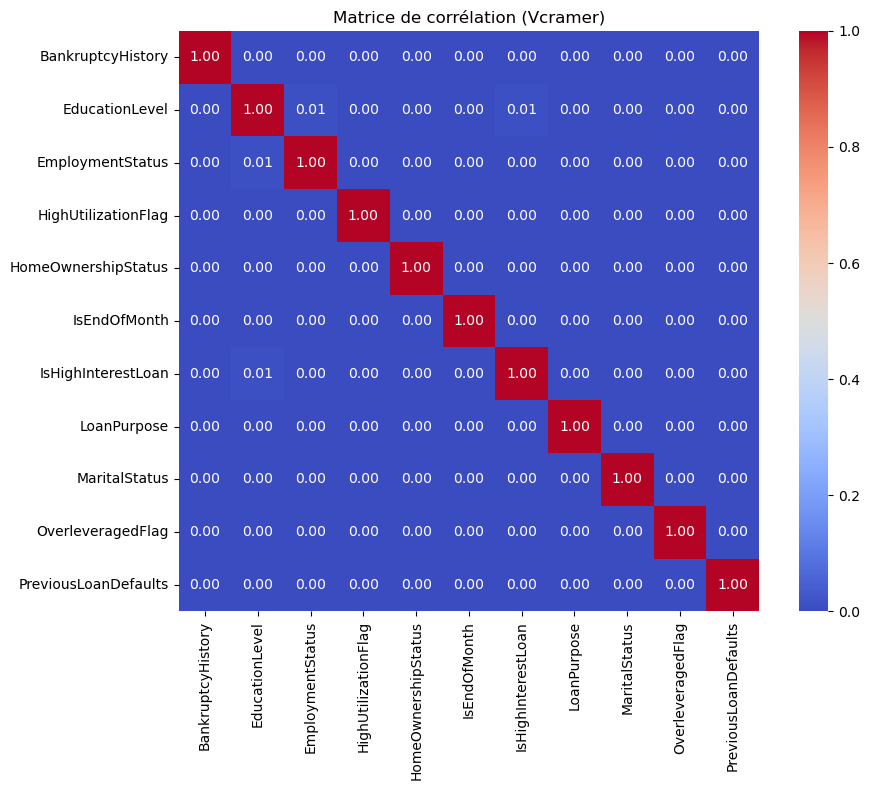

In [138]:
# Affichage de la matrice de corrélation sous forme de heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(v_cramer_resultats, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Matrice de corrélation (Vcramer)')
plt.tight_layout()
plt.show()

In [139]:
#On repère les variables trop corrélées
for i in range(v_cramer_resultats.shape[0]):
  for j in range(i+1,v_cramer_resultats.shape[0]) :
    if v_cramer_resultats.iloc[i,j] > 0.7 :
        print(v_cramer_resultats.index.to_numpy()[i]+" et "+ v_cramer_resultats.columns[j] 
              + " sont trop dépendantes, V-CRAMER = " + str(v_cramer_resultats.iloc[i,j]))

Aucune des variables catégorielles n'a une corrélation de Cramér's V supérieure à 0.8, donc aucune variable n'est redondante. Aucune d'entre elles n'est corrélée avec une autre d'ailleurs (presque toutes les valeurs sont à 0).

## Categorical features encoding

For categorical variables that show an order we use ordered encoding. For other variables, we use one-hot encoding.

In [140]:
for feature in vars_categorielles.columns:
    print(f'{feature}, unique values: {vars_categorielles[feature].unique()}')

BankruptcyHistory, unique values: [0 1]
EducationLevel, unique values: ['Master' 'Associate' 'Bachelor' 'High School' 'Doctorate']
EmploymentStatus, unique values: ['Employed' 'Self-Employed' 'Unemployed']
HighUtilizationFlag, unique values: [1 0]
HomeOwnershipStatus, unique values: ['Own' 'Mortgage' 'Rent' 'Other']
IsEndOfMonth, unique values: [0 1]
IsHighInterestLoan, unique values: [0 1]
LoanPurpose, unique values: ['Home' 'Debt Consolidation' 'Education' 'Other' 'Auto']
MaritalStatus, unique values: ['Married' 'Single' 'Divorced' 'Widowed']
OverleveragedFlag, unique values: [0 1]
PreviousLoanDefaults, unique values: [0 1]


In [141]:
# Suppose vars_categorielles contains all categorical variables
vars_categorielles_encoded = pd.DataFrame()

# Ordinal variable
education_order = ['High School', 'Associate', 'Bachelor', 'Master', 'Doctorate']
ordinal_encoder = OrdinalEncoder(categories=[education_order])
vars_categorielles_encoded['EducationLevel_encoded'] = ordinal_encoder.fit_transform(vars_categorielles[['EducationLevel']]).ravel()

# Nominal variables -> One-Hot
nominal_vars = ['EmploymentStatus', 'HomeOwnershipStatus', 'LoanPurpose', 'MaritalStatus']
onehot_encoder = OneHotEncoder(sparse_output=False, drop='first')
onehot_encoded = onehot_encoder.fit_transform(vars_categorielles[nominal_vars])
onehot_df = pd.DataFrame(onehot_encoded, columns=onehot_encoder.get_feature_names_out(nominal_vars))
vars_categorielles_encoded = pd.concat([vars_categorielles_encoded, onehot_df], axis=1)

# Binary variables -> keep as-is
binary_vars = [
    'BankruptcyHistory', 'HighUtilizationFlag', 'IsEndOfMonth',
    'IsHighInterestLoan', 'OverleveragedFlag', 'PreviousLoanDefaults'
]

vars_categorielles_encoded = pd.concat(
    [vars_categorielles[binary_vars], vars_categorielles_encoded],
    axis=1
)
print(vars_categorielles_encoded)
print(vars_categorielles_encoded.head())

      BankruptcyHistory HighUtilizationFlag IsEndOfMonth IsHighInterestLoan  \
0                     0                   1            0                  0   
1                     0                   0            0                  0   
2                     0                   0            0                  0   
3                     0                   0            0                  1   
4                     0                   1            0                  0   
...                 ...                 ...          ...                ...   
19995                 0                   0            0                  0   
19996                 0                   1            1                  0   
19997                 0                   0            0                  0   
19998                 0                   1            0                  0   
19999                 0                   1            0                  0   

      OverleveragedFlag PreviousLoanDefaults  Educa

In [142]:
for i in vars_categorielles_encoded.columns:
    print(f'{i}, unique values: {vars_categorielles_encoded[i].dtype}')

BankruptcyHistory, unique values: object
HighUtilizationFlag, unique values: object
IsEndOfMonth, unique values: object
IsHighInterestLoan, unique values: object
OverleveragedFlag, unique values: object
PreviousLoanDefaults, unique values: object
EducationLevel_encoded, unique values: float64
EmploymentStatus_Self-Employed, unique values: float64
EmploymentStatus_Unemployed, unique values: float64
HomeOwnershipStatus_Other, unique values: float64
HomeOwnershipStatus_Own, unique values: float64
HomeOwnershipStatus_Rent, unique values: float64
LoanPurpose_Debt Consolidation, unique values: float64
LoanPurpose_Education, unique values: float64
LoanPurpose_Home, unique values: float64
LoanPurpose_Other, unique values: float64
MaritalStatus_Married, unique values: float64
MaritalStatus_Single, unique values: float64
MaritalStatus_Widowed, unique values: float64


## Saving datasets

Gradient Boosting models (like XGBoost, LightGBM) et les algorithmes reposant sur les arbres contiennet des méthodes de sélection de features intégrées. On n'a pas besoin de faire de la sélection de variables avant. 
**data_boosting_models = vars_numeriques+vars_categorielles_encoded**

CatBoosting peut gérer directement les variables catégorielles sans encodage préalable. Comme pour les méthodes de boosting basées sur des arbres, CatBoosting intègre des mécanismes de gestion des variables lui permettant de faire de la sélection de features. 
**data_catboost = vars_numeriques+vars_categorielles**

Pour les méthodes linéaires (Ridge, Lasso, ElasticNet ...) il faut faire de l'encodage et de la sélection de features. 
data_linear_models = **vars_numeriques_reduced+vars_categorielles_encoded**

In [143]:
# modèles linéaires
data1 = pd.concat([vars_numeriques_reduced,vars_categorielles_encoded, y], axis=1)
# modèles basés sur des arbres
data2 = pd.concat([vars_numeriques, vars_categorielles_encoded, y], axis=1)
# catboost
data3 = pd.concat([vars_numeriques, vars_categorielles, y], axis=1)


os.makedirs('../data/data_processed', exist_ok=True)
data1.to_csv('../data/data_processed/data_preprocessing_data1.csv', index=False)
data2.to_csv('../data/data_processed/data_preprocessing_data2.csv', index=False)
data3.to_csv('../data/data_processed/data_preprocessing_data3.csv', index=False)

## Scaling and splitting

In [144]:
# ============================================================================
# DATASET 1: Linear Models (Ridge, Lasso, ElasticNet)
# - vars_numeriques_reduced (handle multicollinearity)
# - vars_categorielles_encoded (with drop='first')
# - Scale: numerical + ordinal
# ============================================================================

print("\nPreparing Dataset 1: Linear Models")

# columns to scale
cols_to_scale_1 = vars_numeriques_reduced.columns.tolist() + ['EducationLevel_encoded']

# columns NOT to scale (binary + one-hot encoded)
binary_vars = ['BankruptcyHistory', 'HighUtilizationFlag', 'IsEndOfMonth',
               'IsHighInterestLoan', 'OverleveragedFlag', 'PreviousLoanDefaults']
cols_not_to_scale_1 = [col for col in vars_categorielles_encoded.columns 
                        if col not in ['EducationLevel_encoded']]

# Combine data before scaling
X1 = pd.concat([vars_numeriques_reduced, vars_categorielles_encoded], axis=1)

# Split first (IMPORTANT: split before scaling to avoid data leakage)
X1_train, X1_test, y1_train, y1_test = train_test_split(
    X1, y, test_size=0.2, random_state=R_seed
)

# Scale on training data
scaler_1 = StandardScaler()
X1_train_scaled = X1_train.copy()
X1_train_scaled[cols_to_scale_1] = scaler_1.fit_transform(X1_train[cols_to_scale_1])

# Transform test data using training scaler
X1_test_scaled = X1_test.copy()
X1_test_scaled[cols_to_scale_1] = scaler_1.transform(X1_test[cols_to_scale_1])

# Save all data in one pickle file - CONVERT TO NUMPY
dataset_1 = {
    'X_train': X1_train_scaled.to_numpy(),
    'X_test': X1_test_scaled.to_numpy(),
    'y_train': y1_train.to_numpy(),
    'y_test': y1_test.to_numpy(),
    'scaler': scaler_1,
    'cols_to_scale': cols_to_scale_1,
    'feature_names': X1_train_scaled.columns.tolist()
}
with open('../data/data_processed/dataset_linear_models.pkl', 'wb') as f:
    pickle.dump(dataset_1, f)

print(f"Dataset 1 - Train shape: {X1_train_scaled.shape}, Test shape: {X1_test_scaled.shape}")
print("Dataset 1 saved to: dataset_linear_models.pkl")

# ============================================================================
# DATASET 2: Tree-based Models (XGBoost, LightGBM, Random Forest)
# - vars_numeriques (full, no multicollinearity removal needed)
# - vars_categorielles_encoded (already encoded)
# - Scale: numerical + ordinal (optional for trees, but doesn't hurt)
# ============================================================================

print("\nPreparing Dataset 2: Tree-based Models")

# Identify columns to scale
cols_to_scale_2 = vars_numeriques.columns.tolist() + ['EducationLevel_encoded']

# Combine data
X2 = pd.concat([vars_numeriques, vars_categorielles_encoded], axis=1)

# Split
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y, test_size=0.2, random_state=R_seed
)

# Scale (optional for trees, but we do it for consistency)
scaler_2 = StandardScaler()
X2_train_scaled = X2_train.copy()
X2_train_scaled[cols_to_scale_2] = scaler_2.fit_transform(X2_train[cols_to_scale_2])

X2_test_scaled = X2_test.copy()
X2_test_scaled[cols_to_scale_2] = scaler_2.transform(X2_test[cols_to_scale_2])

# Save all data in one pickle file - CONVERT TO NUMPY
dataset_2 = {
    'X_train': X2_train_scaled.to_numpy(),
    'X_test': X2_test_scaled.to_numpy(),
    'y_train': y2_train.to_numpy(),
    'y_test': y2_test.to_numpy(),
    'cols_to_scale': cols_to_scale_2,
    'feature_names': X2_train_scaled.columns.tolist()
}
with open('../data/data_processed/dataset_tree_models.pkl', 'wb') as f:
    pickle.dump(dataset_2, f)

print(f"Dataset 2 - Train shape: {X2_train_scaled.shape}, Test shape: {X2_test_scaled.shape}")
print("Dataset 2 saved to: dataset_tree_models.pkl")


# ============================================================================
# DATASET 3: CatBoost (can handle raw categorical variables)
# - vars_numeriques (full)
# - vars_categorielles (raw, NOT encoded)
# - Scale: only numerical variables
# ============================================================================

print("\nPreparing Dataset 3: CatBoost")

# Identify columns to scale (only numerical)
cols_to_scale_3 = vars_numeriques.columns.tolist()

# Combine data (raw categorical)
X3 = pd.concat([vars_numeriques, vars_categorielles], axis=1)

# Split
X3_train, X3_test, y3_train, y3_test = train_test_split(
    X3, y, test_size=0.2, random_state=R_seed
)

# Scale only numerical
scaler_3 = StandardScaler()
X3_train_scaled = X3_train.copy()
X3_train_scaled[cols_to_scale_3] = scaler_3.fit_transform(X3_train[cols_to_scale_3])

X3_test_scaled = X3_test.copy()
X3_test_scaled[cols_to_scale_3] = scaler_3.transform(X3_test[cols_to_scale_3])

# Save categorical feature indices for CatBoost
cat_features_idx = [X3_train_scaled.columns.get_loc(col) for col in vars_categorielles.columns]

# Save all data in one pickle file - CONVERT TO NUMPY
dataset_3 = {
    'X_train': X3_train_scaled.to_numpy(),
    'X_test': X3_test_scaled.to_numpy(),
    'y_train': y3_train.to_numpy(),
    'y_test': y3_test.to_numpy(),
    'scaler': scaler_3,
    'cat_features_idx': cat_features_idx,
    'feature_names': X3_train_scaled.columns.tolist()
}
with open('../data/data_processed/dataset_catboost.pkl', 'wb') as f:
    pickle.dump(dataset_3, f)

print(f"Dataset 3 - Train shape: {X3_train_scaled.shape}, Test shape: {X3_test_scaled.shape}")
print(f"Categorical feature indices: {cat_features_idx}")
print("Dataset 3 saved to: dataset_catboost.pkl")

# ============================================================================
# Summary
# ============================================================================

print("\n" + "="*80)
print("PREPROCESSING COMPLETE - SUMMARY")
print("="*80)
print(f"\nDataset 1 (Linear Models):")
print(f"  - Features: {X1_train_scaled.shape[1]}")
print(f"  - Train samples: {X1_train_scaled.shape[0]}")
print(f"  - Test samples: {X1_test_scaled.shape[0]}")
print(f"  - Scaled columns: {len(cols_to_scale_1)}")

print(f"\nDataset 2 (Tree Models):")
print(f"  - Features: {X2_train_scaled.shape[1]}")
print(f"  - Train samples: {X2_train_scaled.shape[0]}")
print(f"  - Test samples: {X2_test_scaled.shape[0]}")
print(f"  - Scaled columns: {len(cols_to_scale_2)}")

print(f"\nDataset 3 (CatBoost):")
print(f"  - Features: {X3_train_scaled.shape[1]}")
print(f"  - Train samples: {X3_train_scaled.shape[0]}")
print(f"  - Test samples: {X3_test_scaled.shape[0]}")
print(f"  - Scaled columns: {len(cols_to_scale_3)}")
print(f"  - Categorical features: {len(cat_features_idx)}")

print("="*80)
print("="*80)
print("="*80)


Preparing Dataset 1: Linear Models
Dataset 1 - Train shape: (16000, 57), Test shape: (4000, 57)
Dataset 1 saved to: dataset_linear_models.pkl

Preparing Dataset 2: Tree-based Models
Dataset 2 - Train shape: (16000, 75), Test shape: (4000, 75)
Dataset 2 saved to: dataset_tree_models.pkl

Preparing Dataset 3: CatBoost
Dataset 3 - Train shape: (16000, 67), Test shape: (4000, 67)
Categorical feature indices: [56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66]
Dataset 3 saved to: dataset_catboost.pkl

PREPROCESSING COMPLETE - SUMMARY

Dataset 1 (Linear Models):
  - Features: 57
  - Train samples: 16000
  - Test samples: 4000
  - Scaled columns: 39

Dataset 2 (Tree Models):
  - Features: 75
  - Train samples: 16000
  - Test samples: 4000
  - Scaled columns: 57

Dataset 3 (CatBoost):
  - Features: 67
  - Train samples: 16000
  - Test samples: 4000
  - Scaled columns: 56
  - Categorical features: 11


In [145]:
print("All datasets saved in '../data/data_processed/' directory.")

All datasets saved in '../data/data_processed/' directory.
